# 03 - ECT Clinical analysis

This notebook investigates relationships between changes in spectral features of scalp EEG and clinical severity ratings for patients undergoing ECT for treatment resistant depression. 

Symptom severity is assesssed with the HAMD-17 rating scale.

## imports

In [32]:
import numpy as np
import scipy.io as sio
import pandas as pd
import h5py as h5

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from pingouin import corr, ttest

from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn import linear_model

## load EEG features

This cell loads the dataframe with the outputs of the spectral parameterization analysis. Features are then averaged over all electrodes. We are averaging over all electrodes because no spectral features of interest show a characteristic, informative spatial topography. Futhermore, model fits <0.8 are dropped due to poor models fits.

In [2]:
# load dataframe of EEG features
eeg_df = pd.read_csv('../saved_files_appeal/ect_files/ect_all_features.csv', index_col = 0)

# Exclude channels flagged as bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# features to include in analysis
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']

# exclude bad fits
eeg_df_included = eeg_df[eeg_df['exclude']==False]

# average across ALL electrodes
eeg_df_mean = pd.DataFrame(eeg_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

In [3]:
def compute_abundance(df, feature=''):
    """computes abundance as the number of channels containing an oscillation/total channels
    Parameters
    ----------
    Returns
    -------
    """
    features = ['patient','pre_post','channel', feature+'_cf']
    df_osc = pd.DataFrame(df[features])
    df_osc[f'{feature}_present'] = df_osc[feature+'_cf'].notna()
    ch_osc = df_osc.groupby(['patient', 'pre_post'])[f'{feature}_present'].sum().values
    ch_total = df_osc.groupby(['patient', 'pre_post'])['channel'].count().values
    ch_osc_perc = ch_osc/ch_total
    osc_perc_df = pd.DataFrame(df_osc.groupby(['patient', 'pre_post'], as_index=False)[f'{feature}_present'].sum())
    osc_perc_df[f'ch_{feature}_perc'] = ch_osc_perc
    
    return osc_perc_df

In [4]:
delta_perc_df = compute_abundance(eeg_df_included, feature='delta')
theta_perc_df = compute_abundance(eeg_df_included, feature='theta')
alpha_perc_df = compute_abundance(eeg_df_included, feature='alpha')

In [5]:
# merge percentage dfs
perc_df = pd.merge(theta_perc_df, delta_perc_df, how='left', on=['patient', 'pre_post'])
perc_df = pd.merge(perc_df, alpha_perc_df, how='left', on=['patient', 'pre_post'])

In [6]:
# merge perc with main eeg feature df
eeg_df_mean = pd.merge(eeg_df_mean, perc_df, how='left', on=['patient', 'pre_post'])

## convert EEG features dataframe into better format

The ideal dataframe for our analysis has one line for each patient. EEG features are either pre_feature, post_feature, or d_feature.

In [8]:
# pre eeg features
eeg_pre_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='pre'] 

# post eeg features
eeg_post_df_mean = eeg_df_mean[eeg_df_mean['pre_post']=='post'] 

features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent',
            'ch_delta_perc', 'ch_theta_perc', 'ch_alpha_perc']

# difference in eeg features (pre-post)
eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')
eeg_diff_df_mean['patient'] = eeg_df_mean['patient']

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_19204/668889714.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  eeg_diff_df_mean = eeg_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')


In [9]:
eeg_pre_df_mean = eeg_pre_df_mean.rename(columns={c: 'pre_'+c for c in eeg_pre_df_mean.columns if c not in ['patient']})
eeg_post_df_mean = eeg_post_df_mean.rename(columns={c: 'post_'+c for c in eeg_post_df_mean.columns if c not in ['patient']})
eeg_diff_df_mean = eeg_diff_df_mean.rename(columns={c: 'diff_'+c for c in eeg_diff_df_mean.columns if c not in ['patient']})


In [10]:
eeg_pre_post = pd.merge(eeg_pre_df_mean, eeg_post_df_mean, on='patient', how='left')
eeg_pre_post_diff = pd.merge(eeg_pre_post, eeg_diff_df_mean, on='patient', how='left')

In [11]:
eeg_pre_post_diff = eeg_pre_post_diff.drop(labels=['pre_pre_post', 'post_pre_post'], axis='columns')

In [12]:
eeg_pre_post_diff

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_theta_bp,diff_alpha_cf,diff_alpha_bw,diff_alpha_amp,diff_alpha_bp,diff_offset,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc
0,3,1.438948,1.443764,0.110584,-12.143266,6.654823,1.317414,0.283711,-12.224720,10.035655,...,-1.047483,0.081001,-1.181671,0.275602,-0.286402,-1.257006,-0.921488,-0.283333,-0.283333,0.016667
1,4,2.387229,1.000000,0.210006,-11.752841,5.305208,1.000000,0.290177,-12.230327,10.042907,...,0.160953,0.813720,0.140621,0.476360,0.772309,0.295766,-0.165961,-0.033333,-0.816667,0.000000
2,10,3.423894,1.104140,0.082961,-11.983244,5.749722,1.654258,0.229451,-12.161033,10.368317,...,-1.067190,1.695906,-1.102768,-0.338883,-0.726749,-0.580045,-0.353966,0.116667,-0.283333,0.000000
3,13,2.084120,1.086628,0.151263,-11.884587,6.155017,1.000000,0.370829,-12.171802,7.716012,...,-0.212238,0.028742,-0.080232,0.100156,-0.051523,-0.172336,-0.081453,-0.016667,-0.166667,0.000000
4,16,NaN,NaN,NaN,-12.021677,5.829376,1.298820,0.213585,-12.270817,10.179327,...,-1.106876,1.022782,-2.992160,0.124481,-0.211126,-0.712337,-0.495305,-0.133333,-0.316667,0.000000
5,18,NaN,NaN,NaN,-12.055804,NaN,NaN,NaN,-12.413767,8.770979,...,-0.899623,0.645290,-2.516315,-0.351969,-0.668322,-0.656820,-0.451485,-0.050000,-0.466667,0.133333
6,19,1.795695,2.080280,0.437818,-12.283438,5.114885,1.000000,0.019979,-12.938969,10.996998,...,-0.507658,1.255797,-0.260381,0.767590,0.051426,-0.437258,-0.056655,0.133333,-0.044444,0.022222
7,25,1.019176,1.393143,0.660009,-12.462645,6.509492,1.371073,0.196186,-12.815812,9.992815,...,-1.560811,1.123630,-4.015184,-0.028929,-1.114945,-1.451715,-0.655069,-0.338983,-0.644068,0.322034
8,29,2.782061,1.227346,0.170537,-12.169326,4.744697,1.495156,0.171287,-12.711118,8.699784,...,-1.644640,1.133505,-3.151910,-0.462284,-1.134528,-1.109276,-0.431640,-0.100000,0.416667,0.100000
9,31,3.550182,1.236522,0.561487,-11.080814,5.791848,2.856114,0.384576,-11.331101,9.514552,...,-0.846204,0.572586,-1.320593,0.738248,0.159967,-1.013398,-0.760363,-0.383333,-0.166667,0.000000


## load clinical features CSV

This cell loads the dataframes with clinical ratings and demographics. These dataframes are then refactored into a single clinical dataframe with the relevant features included.

In [13]:
ECT_clinical = pd.read_csv('../saved_files_appeal/ect_files/ect_clinical_data/ECT_clinical.csv')
ECT_HAMD = pd.read_csv('../saved_files_appeal/ect_files/ect_clinical_data/ECT_HAMD.csv')
exp_df = pd.read_csv('../saved_files_appeal/ect_files/ect_all_features.csv', index_col=0)

# rename columns

ECT_HAMD = ECT_HAMD[['subject', 'TotalPre', 'TotalPost']].copy().rename(columns={'subject': 'patient',
                                                                                 'TotalPre': 'pre_HAMD',
                                                                                 'TotalPost': 'post_HAMD'})
ECT_clinical = ECT_clinical[['subject', 'x_OfTxsReceived']].copy().rename(columns={'subject': 'patient',
                                                                                   'x_OfTxsReceived': 'n_TxsReceived'})

# merge into single dataframe
all_clinical = pd.merge(ECT_HAMD, ECT_clinical, on='patient', how='outer')

## note about merging clinical and EEG data

Merge dataframes at an ad-hoc basis for the demands of each regression formula 

In [14]:
clin_eeg_df = pd.merge(eeg_pre_post_diff, all_clinical, on='patient', how='left')

In [15]:
clin_eeg_df

,patient,pre_delta_cf,pre_delta_bw,pre_delta_amp,pre_delta_bp,pre_theta_cf,pre_theta_bw,pre_theta_amp,pre_theta_bp,pre_alpha_cf,...,diff_alpha_amp,diff_alpha_bp,diff_offset,diff_exponent,diff_ch_delta_perc,diff_ch_theta_perc,diff_ch_alpha_perc,pre_HAMD,post_HAMD,n_TxsReceived
0,3,1.438948,1.443764,0.110584,-12.143266,6.654823,1.317414,0.283711,-12.224720,10.035655,...,0.275602,-0.286402,-1.257006,-0.921488,-0.283333,-0.283333,0.016667,33.0,7.0,8.0
1,4,2.387229,1.000000,0.210006,-11.752841,5.305208,1.000000,0.290177,-12.230327,10.042907,...,0.476360,0.772309,0.295766,-0.165961,-0.033333,-0.816667,0.000000,24.0,13.0,10.0
2,10,3.423894,1.104140,0.082961,-11.983244,5.749722,1.654258,0.229451,-12.161033,10.368317,...,-0.338883,-0.726749,-0.580045,-0.353966,0.116667,-0.283333,0.000000,21.0,20.0,11.0
3,13,2.084120,1.086628,0.151263,-11.884587,6.155017,1.000000,0.370829,-12.171802,7.716012,...,0.100156,-0.051523,-0.172336,-0.081453,-0.016667,-0.166667,0.000000,25.0,22.0,15.0
4,16,NaN,NaN,NaN,-12.021677,5.829376,1.298820,0.213585,-12.270817,10.179327,...,0.124481,-0.211126,-0.712337,-0.495305,-0.133333,-0.316667,0.000000,24.0,NaN,14.0
5,18,NaN,NaN,NaN,-12.055804,NaN,NaN,NaN,-12.413767,8.770979,...,-0.351969,-0.668322,-0.656820,-0.451485,-0.050000,-0.466667,0.133333,23.0,30.0,17.0
6,19,1.795695,2.080280,0.437818,-12.283438,5.114885,1.000000,0.019979,-12.938969,10.996998,...,0.767590,0.051426,-0.437258,-0.056655,0.133333,-0.044444,0.022222,34.0,12.0,11.0
7,25,1.019176,1.393143,0.660009,-12.462645,6.509492,1.371073,0.196186,-12.815812,9.992815,...,-0.028929,-1.114945,-1.451715,-0.655069,-0.338983,-0.644068,0.322034,NaN,NaN,NaN
8,29,2.782061,1.227346,0.170537,-12.169326,4.744697,1.495156,0.171287,-12.711118,8.699784,...,-0.462284,-1.134528,-1.109276,-0.431640,-0.100000,0.416667,0.100000,NaN,NaN,NaN
9,31,3.550182,1.236522,0.561487,-11.080814,5.791848,2.856114,0.384576,-11.331101,9.514552,...,0.738248,0.159967,-1.013398,-0.760363,-0.383333,-0.166667,0.000000,23.0,9.0,17.0


In [16]:
features = ['pre_delta_amp', 'pre_theta_amp', 'pre_alpha_amp', 'pre_exponent', 'pre_ch_delta_perc',
            'diff_delta_amp', 'diff_theta_amp', 'diff_alpha_amp', 'diff_exponent',
            'diff_ch_delta_perc', 'diff_ch_theta_perc', 'diff_ch_alpha_perc', 
            'pre_HAMD', 'post_HAMD', 'n_TxsReceived']

<AxesSubplot:>

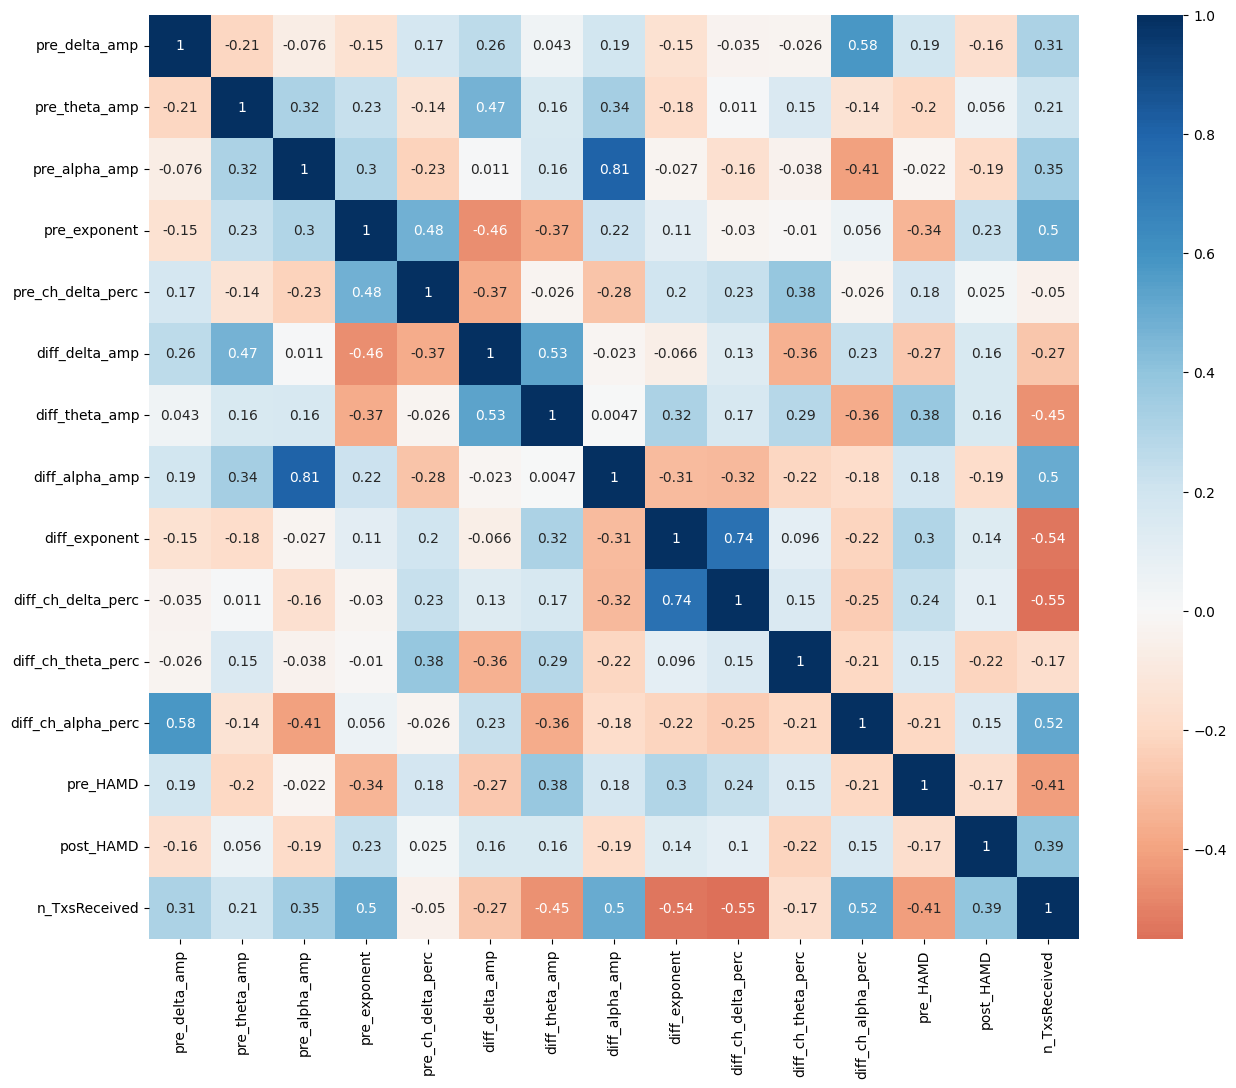

In [17]:
plt.figure(figsize=[15,12])
sns.heatmap(clin_eeg_df[features].corr(), cmap='RdBu', center=0, annot=True)

# Stepwise Linear Regression

Working backwards, remove features from the multiple linear regression model in order to best predict the outcome of treatment. We will do 3 different versions. 

1) final HAMD with baseline as a feature `post_HAMD ~ pre_HAMD + feature_1 + .... + feature_n`  
2) HAMD difference `pre_HAMD - post_HAMD ~ feature_1 + .... + feature_n`  
3) HAMD ratio `(pre_HAMD - post_HAMD)/pre_HAMD ~ feature_1 + .... + feature_n`  


Here is an exhaustive list of the features to be included in the model, not to exceed 18, due to number of subjects:

n = 14  
`'pre_delta_amp', 'pre_theta_amp', 'pre_alpha_amp', 'pre_exponent', 'pre_ch_delta_perc', 
'diff_delta_amp', 'diff_theta_amp', 'diff_alpha_amp', 'diff_exponent',
'diff_ch_delta_perc', 'diff_ch_theta_perc', 'diff_ch_alpha_perc', 
'pre_HAMD', 'n_TxsReceived'`

The following interaction terms should also be considered because their correlation coefficients are greater than 0.4:

n = 15  
`'pre_ch_delta_perc:pre_exponent', 'diff_delta_amp:pre_theta_amp', 'diff_delta_amp:pre_exponent', 'diff_theta_amp:diff_delta_amp', *'diff_alpha_amp:pre_alpha_amp', *'diff_ch_delta_perc:diff_exponent', 'diff_ch_alpha_perc:pre_delta_amp', 'diff_ch_alpha_perc:pre_alpha_amp', *'n_TxsReceived:pre_exponent', *'n_TxsReceived:diff_theta_amp', *'n_TxsReceived:diff_alpha_amp', *'n_TxsReceived:diff_exponent', *'n_TxsRecieved:diff_ch_delta_perc', *'n_TxsReceived:diff_ch_alpha_perc', *'n_TxsReceived:pre_HAMD'`

Correlations that are significant or trending are *

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


,n,r,CI95%,p-val,BF10,power
pearson,22,0.108111,"[-0.33, 0.51]",0.632016,0.294,0.076375


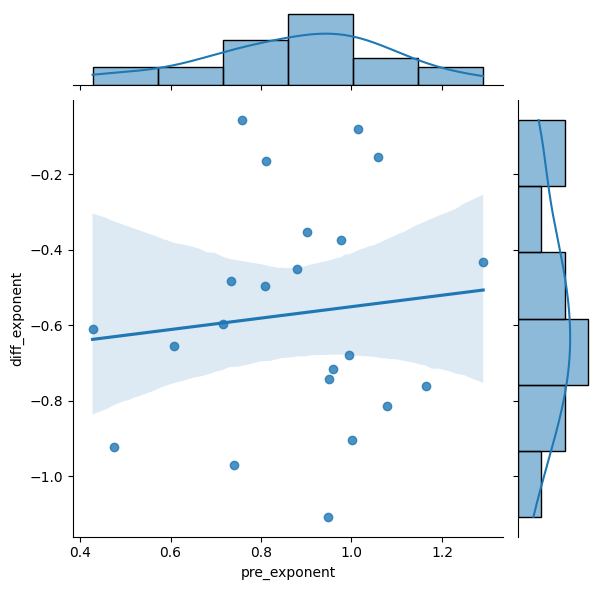

In [125]:
x = clin_eeg_df['pre_exponent']
y = clin_eeg_df['diff_exponent']

sns.jointplot(x, y, kind="reg")

corr(x,y)

## 1) Final HAMD w/ baseline as a feature

In [119]:
formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + pre_ch_delta_perc + pre_ch_theta_perc + \
           diff_exponent + diff_ch_delta_perc + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_exponent + n_TxsReceived:diff_ch_delta_perc + \
           n_TxsReceived:pre_HAMD'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                 -0.309
Method:                 Least Squares   F-statistic:                    0.6913
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.726
Time:                        15:49:13   Log-Likelihood:                -48.586
No. Observations:                  18   AIC:                             125.2
Df Residuals:                       4   BIC:                             137.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [120]:
# take out pre_ch_delta_perc
formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + pre_ch_theta_perc + \
           diff_exponent + diff_ch_delta_perc + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_exponent + n_TxsReceived:diff_ch_delta_perc + \
           n_TxsReceived:pre_HAMD'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                 -0.047
Method:                 Least Squares   F-statistic:                    0.9361
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.575
Time:                        15:50:34   Log-Likelihood:                -48.586
No. Observations:                  18   AIC:                             123.2
Df Residuals:                       5   BIC:                             134.7
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [121]:
# take out pre_ch_theta_perc
formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + \
           diff_exponent + diff_ch_delta_perc + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_exponent + n_TxsReceived:diff_ch_delta_perc + \
           n_TxsReceived:pre_HAMD'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     1.225
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.421
Time:                        15:52:05   Log-Likelihood:                -48.587
No. Observations:                  18   AIC:                             121.2
Df Residuals:                       6   BIC:                             131.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [122]:
# take out diff_ch_delta_perc
formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + \
           diff_exponent + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_exponent + n_TxsReceived:diff_ch_delta_perc + \
           n_TxsReceived:pre_HAMD'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     1.557
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.286
Time:                        15:53:14   Log-Likelihood:                -48.649
No. Observations:                  18   AIC:                             119.3
Df Residuals:                       7   BIC:                             129.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [123]:
# take out n_TxsReceived:diff_exponent
formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + \
           diff_exponent + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_ch_delta_perc + \
           n_TxsReceived:pre_HAMD'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.687
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     1.950
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.180
Time:                        15:54:47   Log-Likelihood:                -48.735
No. Observations:                  18   AIC:                             117.5
Df Residuals:                       8   BIC:                             126.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [124]:
# take out n_TxsReceived:pre_HAMD
formula = 'post_HAMD  ~ pre_HAMD + pre_exponent + \
           diff_exponent + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.681
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     2.406
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.106
Time:                        15:57:29   Log-Likelihood:                -48.892
No. Observations:                  18   AIC:                             115.8
Df Residuals:                       9   BIC:                             123.8
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [126]:
# take out pre_exponent
formula = 'post_HAMD  ~ pre_HAMD  + \
           diff_exponent + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     2.957
Date:                Fri, 12 May 2023   Prob (F-statistic):             0.0589
Time:                        16:01:15   Log-Likelihood:                -49.090
No. Observations:                  18   AIC:                             114.2
Df Residuals:                      10   BIC:                             121.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [127]:
# take out n_TxsReceived:pre_exponent
formula = 'post_HAMD  ~ pre_HAMD  + \
           diff_exponent + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + \
           n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                     3.261
Date:                Fri, 12 May 2023   Prob (F-statistic):             0.0429
Time:                        16:02:29   Log-Likelihood:                -49.987
No. Observations:                  18   AIC:                             114.0
Df Residuals:                      11   BIC:                             120.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [128]:
# take out diff_ch_theta_perc
formula = 'post_HAMD  ~ pre_HAMD  + \
           diff_exponent + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + \
           n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.601
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     3.616
Date:                Fri, 12 May 2023   Prob (F-statistic):             0.0316
Time:                        16:03:25   Log-Likelihood:                -50.915
No. Observations:                  18   AIC:                             113.8
Df Residuals:                      12   BIC:                             119.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [129]:
# take out diff_exponent
formula = 'post_HAMD  ~ pre_HAMD  + \
           n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + \
           n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              post_HAMD   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     2.831
Date:                Fri, 12 May 2023   Prob (F-statistic):             0.0686
Time:                        16:05:58   Log-Likelihood:                -53.546
No. Observations:                  18   AIC:                             117.1
Df Residuals:                      13   BIC:                             121.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


# Halle-fucking-lujah

Removing exponent makes the model no longer significant

# 2) Difference in HAMD

In [138]:
formula = 'pre_HAMD - post_HAMD  ~ pre_exponent + pre_ch_delta_perc + pre_ch_theta_perc + \
           diff_exponent + diff_ch_delta_perc + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_exponent + n_TxsReceived:diff_ch_delta_perc + \
           n_TxsReceived'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                 -0.470
Method:                 Least Squares   F-statistic:                    0.4769
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.869
Time:                        16:27:23   Log-Likelihood:                -46.283
No. Observations:                  19   AIC:                             116.6
Df Residuals:                       7   BIC:                             127.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [131]:
# take out pre_ch_delta_perc
formula = 'pre_HAMD - post_HAMD  ~ pre_exponent + pre_ch_theta_perc + \
           diff_exponent + diff_ch_delta_perc + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_exponent + n_TxsReceived:diff_ch_delta_perc + \
           n_TxsReceived'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                 -0.286
Method:                 Least Squares   F-statistic:                    0.5993
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.780
Time:                        16:21:21   Log-Likelihood:                -46.285
No. Observations:                  19   AIC:                             114.6
Df Residuals:                       8   BIC:                             125.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [132]:
# take out diff_ch_delta_perc
formula = 'pre_HAMD - post_HAMD  ~ pre_exponent + pre_ch_theta_perc + \
           diff_exponent + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_exponent + n_TxsReceived:diff_ch_delta_perc + \
           n_TxsReceived'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                 -0.159
Method:                 Least Squares   F-statistic:                    0.7254
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.680
Time:                        16:21:56   Log-Likelihood:                -46.415
No. Observations:                  19   AIC:                             112.8
Df Residuals:                       9   BIC:                             122.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [133]:
# take out n_TxsReceived:diff_exponent 
formula = 'pre_HAMD - post_HAMD  ~ pre_exponent + pre_ch_theta_perc + \
           diff_exponent + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_ch_delta_perc + \
           n_TxsReceived'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                 -0.064
Method:                 Least Squares   F-statistic:                    0.8649
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.573
Time:                        16:22:39   Log-Likelihood:                -46.601
No. Observations:                  19   AIC:                             111.2
Df Residuals:                      10   BIC:                             119.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [134]:
# take out diff_ch_theta_perc 
formula = 'pre_HAMD - post_HAMD  ~ pre_exponent + pre_ch_theta_perc + \
           diff_exponent + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_ch_delta_perc + \
           n_TxsReceived'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.9794
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.491
Time:                        16:23:46   Log-Likelihood:                -46.994
No. Observations:                  19   AIC:                             110.0
Df Residuals:                      11   BIC:                             117.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [135]:
# take out pre_ch_theta_perc 
formula = 'pre_HAMD - post_HAMD  ~ pre_exponent + \
           diff_exponent + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_ch_delta_perc + \
           n_TxsReceived'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.122
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.405
Time:                        16:24:17   Log-Likelihood:                -47.364
No. Observations:                  19   AIC:                             108.7
Df Residuals:                      12   BIC:                             115.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [136]:
# take out n_TxsReceived 
formula = 'pre_HAMD - post_HAMD  ~ pre_exponent + \
           diff_exponent + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_ch_delta_perc '

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.103
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.405
Time:                        16:25:10   Log-Likelihood:                -48.238
No. Observations:                  19   AIC:                             108.5
Df Residuals:                      13   BIC:                             114.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [137]:
# take out n_TxsReceived:pre_exponent 
formula = 'pre_HAMD - post_HAMD  ~ pre_exponent + \
           diff_exponent + \
           diff_ch_delta_perc:diff_exponent + \
           n_TxsReceived:diff_ch_delta_perc '

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     1.450
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.269
Time:                        16:26:10   Log-Likelihood:                -48.303
No. Observations:                  19   AIC:                             106.6
Df Residuals:                      14   BIC:                             111.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [139]:
# take out pre_exponent 
formula = 'pre_HAMD - post_HAMD ~ diff_exponent + \
           diff_ch_delta_perc:diff_exponent + \
           n_TxsReceived:diff_ch_delta_perc '

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     1.832
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.185
Time:                        16:28:13   Log-Likelihood:                -48.631
No. Observations:                  19   AIC:                             105.3
Df Residuals:                      15   BIC:                             109.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [140]:
# take out diff_exponent 
formula = 'pre_HAMD - post_HAMD ~ diff_ch_delta_perc:diff_exponent + \
           n_TxsReceived:diff_ch_delta_perc '

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     2.311
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.131
Time:                        16:28:48   Log-Likelihood:                -49.185
No. Observations:                  19   AIC:                             104.4
Df Residuals:                      16   BIC:                             107.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [141]:
# take out diff_exponent 
formula = 'pre_HAMD - post_HAMD ~  n_TxsReceived:diff_ch_delta_perc '

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     2.318
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.146
Time:                        16:31:02   Log-Likelihood:                -50.382
No. Observations:                  19   AIC:                             104.8
Df Residuals:                      17   BIC:                             106.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


this regression never approaches statistical significance.

# 3) HAMD ratio

In [143]:
formula = '(pre_HAMD - post_HAMD) / pre_HAMD ~ pre_exponent + pre_ch_delta_perc + pre_ch_theta_perc + \
           diff_exponent + diff_ch_delta_perc + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_exponent + n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                 -0.470
Method:                 Least Squares   F-statistic:                    0.4769
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.869
Time:                        16:33:30   Log-Likelihood:                -46.283
No. Observations:                  19   AIC:                             116.6
Df Residuals:                       7   BIC:                             127.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [144]:
# take out pre_ch_delta_perc
formula = '(pre_HAMD - post_HAMD) / pre_HAMD ~ pre_exponent + pre_ch_theta_perc + \
           diff_exponent + diff_ch_delta_perc + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_exponent + n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                 -0.286
Method:                 Least Squares   F-statistic:                    0.5993
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.780
Time:                        16:34:39   Log-Likelihood:                -46.285
No. Observations:                  19   AIC:                             114.6
Df Residuals:                       8   BIC:                             125.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [145]:
# take out diff_ch_delta_perc
formula = '(pre_HAMD - post_HAMD) / pre_HAMD ~ pre_exponent + pre_ch_theta_perc + \
           diff_exponent + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_exponent + n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                 -0.159
Method:                 Least Squares   F-statistic:                    0.7254
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.680
Time:                        16:35:08   Log-Likelihood:                -46.415
No. Observations:                  19   AIC:                             112.8
Df Residuals:                       9   BIC:                             122.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [146]:
# take out n_TxsReceived:diff_exponent
formula = '(pre_HAMD - post_HAMD) / pre_HAMD ~ pre_exponent + pre_ch_theta_perc + \
           diff_exponent + diff_ch_theta_perc + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                 -0.064
Method:                 Least Squares   F-statistic:                    0.8649
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.573
Time:                        16:36:07   Log-Likelihood:                -46.601
No. Observations:                  19   AIC:                             111.2
Df Residuals:                      10   BIC:                             119.7
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [147]:
# take out diff_ch_theta_perc
formula = '(pre_HAMD - post_HAMD) / pre_HAMD ~ pre_exponent + pre_ch_theta_perc + \
           diff_exponent + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.384
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.9794
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.491
Time:                        16:36:52   Log-Likelihood:                -46.994
No. Observations:                  19   AIC:                             110.0
Df Residuals:                      11   BIC:                             117.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [148]:
# take out pre_ch_theta_perc
formula = '(pre_HAMD - post_HAMD) / pre_HAMD ~ pre_exponent + \
           diff_exponent + n_TxsReceived + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.359
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     1.122
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.405
Time:                        16:37:29   Log-Likelihood:                -47.364
No. Observations:                  19   AIC:                             108.7
Df Residuals:                      12   BIC:                             115.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [149]:
# take out n_TxsReceived
formula = '(pre_HAMD - post_HAMD) / pre_HAMD ~ pre_exponent + \
           diff_exponent + \
           diff_ch_delta_perc:diff_exponent + n_TxsReceived:pre_exponent + \
           n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     1.103
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.405
Time:                        16:38:05   Log-Likelihood:                -48.238
No. Observations:                  19   AIC:                             108.5
Df Residuals:                      13   BIC:                             114.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [150]:
# take out n_TxsReceived:pre_exponent
formula = '(pre_HAMD - post_HAMD) / pre_HAMD ~ pre_exponent + \
           diff_exponent + \
           diff_ch_delta_perc:diff_exponent + \
           n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     1.450
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.269
Time:                        16:38:53   Log-Likelihood:                -48.303
No. Observations:                  19   AIC:                             106.6
Df Residuals:                      14   BIC:                             111.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [151]:
# take out pre_exponent
formula = '(pre_HAMD - post_HAMD) / pre_HAMD ~ diff_exponent + \
           diff_ch_delta_perc:diff_exponent + \
           n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     1.832
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.185
Time:                        16:39:28   Log-Likelihood:                -48.631
No. Observations:                  19   AIC:                             105.3
Df Residuals:                      15   BIC:                             109.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [152]:
# take out diff_exponent
formula = '(pre_HAMD - post_HAMD) / pre_HAMD ~ diff_ch_delta_perc:diff_exponent + \
           n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     2.311
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.131
Time:                        16:40:04   Log-Likelihood:                -49.185
No. Observations:                  19   AIC:                             104.4
Df Residuals:                      16   BIC:                             107.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [153]:
# take out diff_exponent
formula = '(pre_HAMD - post_HAMD) / pre_HAMD ~ n_TxsReceived:diff_ch_delta_perc'

model = ols(formula, clin_eeg_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               pre_HAMD   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     2.318
Date:                Fri, 12 May 2023   Prob (F-statistic):              0.146
Time:                        16:40:35   Log-Likelihood:                -50.382
No. Observations:                  19   AIC:                             104.8
Df Residuals:                      17   BIC:                             106.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


This model never approaches significance. However, for both models, diff_exponenet is one of the last predictors to be removed from the model.